In [1]:
from google.colab import files
import pandas as pd

# Upload the train dataset
uploaded = files.upload()

# Read the train dataset
df = pd.read_csv('train.csv')

# Check first few rows
df.head()



Saving train.csv to train.csv


,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [2]:
# Check missing values
print("Before filling missing values:")
print(df.isnull().sum())

# Fill missing numerical values with mean
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# Verify no missing values remain
print("\nAfter filling missing values:")
print(df.isnull().sum())


Before filling missing values:
Customer ID                       0
Name                              0
Gender                           53
Age                               0
Income (USD)                   4576
Income Stability               1683
Profession                        0
Type of Employment             7270
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     172
Expense Type 1                    0
Expense Type 2                    0
Dependents                     2493
Credit Score                   1703
No. of Defaults                   0
Has Active Credit Card         1566
Property ID                       0
Property Age                   4850
Property Type                     0
Property Location               356
Co-Applicant                      0
Property Price                    0
Loan Sanction Amount (USD)      340
dtype: int64

After filling missing values:
Customer ID                    0
Name                        

In [3]:
# Display first few rows to check
df.head()


,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.050000,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,Active,746,1933.05000,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.910000,Low,Working,Laborers,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91000,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.190000,High,Pensioner,Laborers,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19000,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,2630.574417,High,Pensioner,Laborers,Rural,80057.92,...,832.70,1,Unpossessed,890,2631.11944,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.770000,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77000,4,Semi-Urban,1,208567.91,74008.28


feauture engineering


In [4]:
unnecessary_columns = ['Customer ID', 'Name', 'Property ID']
df.drop(columns=unnecessary_columns, inplace=True)

In [5]:
# Convert required columns to numeric in case they are strings
df['Loan Amount Request (USD)'] = pd.to_numeric(df['Loan Amount Request (USD)'], errors='coerce')
df['Property Price'] = pd.to_numeric(df['Property Price'], errors='coerce')
df['Income (USD)'] = pd.to_numeric(df['Income (USD)'], errors='coerce')
df['Current Loan Expenses (USD)'] = pd.to_numeric(df['Current Loan Expenses (USD)'], errors='coerce')

# 1. LTV Risk Category
def ltv_risk_category(row):
    loan_amount = row['Loan Amount Request (USD)']
    property_price = row['Property Price']

    if pd.isna(loan_amount) or pd.isna(property_price) or property_price == 0:
        return 'Unknown'

    ltv = loan_amount / property_price

    if ltv >= 0.9:
        return 'Very High'
    elif ltv >= 0.75:
        return 'High'
    elif ltv >= 0.6:
        return 'Moderate'
    else:
        return 'Low'

df['LTV_Risk'] = df.apply(ltv_risk_category, axis=1)

# 2. Loan-to-Income Ratio
df['Loan_to_Income'] = df['Loan Amount Request (USD)'] / (df['Income (USD)'] + 1e-5)

# 3. Total Expenses-to-Income Ratio
df['Total_Expenses_to_Income'] = df['Current Loan Expenses (USD)'] / (df['Income (USD)'] + 1e-5)

# Preview the dataset
df.head()


,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,...,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),LTV_Risk,Loan_to_Income,Total_Expenses_to_Income
0,F,56,1933.050000,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,...,Active,1933.05000,4,Rural,1,119933.46,54607.18,Moderate,37.665647,0.124715
1,M,32,4952.910000,Low,Working,Laborers,Semi-Urban,46837.47,495.81,N,...,Unpossessed,4952.91000,2,Rural,1,54791.00,37469.98,High,9.456556,0.100105
2,F,65,988.190000,High,Pensioner,Laborers,Semi-Urban,45593.04,171.95,N,...,Unpossessed,988.19000,2,Urban,0,72440.58,36474.43,Moderate,46.137928,0.174005
3,F,65,2630.574417,High,Pensioner,Laborers,Rural,80057.92,298.54,N,...,Unpossessed,2631.11944,2,Semi-Urban,1,121441.51,56040.54,Moderate,30.433627,0.113489
4,F,31,2614.770000,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,...,Active,2614.77000,4,Semi-Urban,1,208567.91,74008.28,Low,43.544514,0.187936


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

# Convert all object columns to string first (to avoid mixed types)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str)  # ✅ Ensures uniform type

    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Check data after encoding
df.head()


,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,...,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),LTV_Risk,Loan_to_Income,Total_Expenses_to_Income
0,0,56,1933.050000,1,7,14,1,72809.58,241.08,0,...,0,1933.05000,4,0,1,119933.46,54607.18,2,37.665647,0.124715
1,1,32,4952.910000,1,7,8,1,46837.47,495.81,0,...,2,4952.91000,2,0,1,54791.00,37469.98,0,9.456556,0.100105
2,0,65,988.190000,0,3,8,1,45593.04,171.95,0,...,2,988.19000,2,2,0,72440.58,36474.43,2,46.137928,0.174005
3,0,65,2630.574417,0,3,8,0,80057.92,298.54,0,...,2,2631.11944,2,1,1,121441.51,56040.54,2,30.433627,0.113489
4,0,31,2614.770000,1,7,6,1,113858.89,491.41,0,...,0,2614.77000,4,1,1,208567.91,74008.28,1,43.544514,0.187936


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Drop the target column 'Loan Sanction Amount (USD)' while scaling features
features = df.drop('Loan Sanction Amount (USD)', axis=1)

# Fit and transform features
fs = scaler.fit_transform(features)

# Convert back to DataFrame for ease of use
fs = pd.DataFrame(fs, columns=features.columns)

# Add target column back for reference
fs['Loan Sanction Amount (USD)'] = df['Loan Sanction Amount (USD)']

fs.head()


,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,...,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,LTV_Risk,Loan_to_Income,Total_Expenses_to_Income,Loan Sanction Amount (USD)
0,-1.007092,0.991451,-0.067276,0.305833,0.834973,1.569338,0.142149,-0.269027,-0.660989,-0.749241,...,-1.126689,-6.733638e-02,1.376731,-1.214540,0.076982,-0.126419,0.986797,-0.006611,-0.445751,54607.18
1,0.992958,-0.504355,0.223990,0.305833,0.834973,0.027732,0.142149,-0.705269,0.392289,-0.749241,...,1.299777,2.239619e-01,-0.411309,-1.214540,0.076982,-0.822772,-1.381989,-1.117247,-0.676972,37469.98
2,-1.007092,1.552379,-0.158409,-3.269763,-0.686548,0.027732,0.142149,-0.726171,-0.946833,-0.749241,...,1.299777,-1.584784e-01,-0.411309,1.283229,0.063579,-0.634103,0.986797,0.326956,0.017348,36474.43
3,-1.007092,1.552379,0.000000,-3.269763,-0.686548,0.027732,-1.762481,-0.147279,-0.423399,-0.749241,...,1.299777,8.773064e-17,-0.411309,0.034344,0.076982,-0.110298,0.986797,-0.291347,-0.551227,56040.54
4,-1.007092,-0.566680,-0.001524,0.305833,0.834973,-0.486137,0.142149,0.420461,0.374095,-0.749241,...,-1.126689,-1.577081e-03,1.376731,0.034344,0.076982,0.821057,-0.197596,0.224849,0.148237,74008.28


# **eda**

In [8]:
# Number of rows and columns
print("Dataset shape:", fs.shape)

# Column names and their data types
print("\nData types:\n", fs.dtypes)

# First few rows to peek at the data
fs.head()


Dataset shape: (30000, 24)

Data types:
 Gender                         float64
Age                            float64
Income (USD)                   float64
Income Stability               float64
Profession                     float64
Type of Employment             float64
Location                       float64
Loan Amount Request (USD)      float64
Current Loan Expenses (USD)    float64
Expense Type 1                 float64
Expense Type 2                 float64
Dependents                     float64
Credit Score                   float64
No. of Defaults                float64
Has Active Credit Card         float64
Property Age                   float64
Property Type                  float64
Property Location              float64
Co-Applicant                   float64
Property Price                 float64
LTV_Risk                       float64
Loan_to_Income                 float64
Total_Expenses_to_Income       float64
Loan Sanction Amount (USD)     float64
dtype: object


,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,...,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,LTV_Risk,Loan_to_Income,Total_Expenses_to_Income,Loan Sanction Amount (USD)
0,-1.007092,0.991451,-0.067276,0.305833,0.834973,1.569338,0.142149,-0.269027,-0.660989,-0.749241,...,-1.126689,-6.733638e-02,1.376731,-1.214540,0.076982,-0.126419,0.986797,-0.006611,-0.445751,54607.18
1,0.992958,-0.504355,0.223990,0.305833,0.834973,0.027732,0.142149,-0.705269,0.392289,-0.749241,...,1.299777,2.239619e-01,-0.411309,-1.214540,0.076982,-0.822772,-1.381989,-1.117247,-0.676972,37469.98
2,-1.007092,1.552379,-0.158409,-3.269763,-0.686548,0.027732,0.142149,-0.726171,-0.946833,-0.749241,...,1.299777,-1.584784e-01,-0.411309,1.283229,0.063579,-0.634103,0.986797,0.326956,0.017348,36474.43
3,-1.007092,1.552379,0.000000,-3.269763,-0.686548,0.027732,-1.762481,-0.147279,-0.423399,-0.749241,...,1.299777,8.773064e-17,-0.411309,0.034344,0.076982,-0.110298,0.986797,-0.291347,-0.551227,56040.54
4,-1.007092,-0.566680,-0.001524,0.305833,0.834973,-0.486137,0.142149,0.420461,0.374095,-0.749241,...,-1.126689,-1.577081e-03,1.376731,0.034344,0.076982,0.821057,-0.197596,0.224849,0.148237,74008.28


In [9]:
fs.describe()


,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,...,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,LTV_Risk,Loan_to_Income,Total_Expenses_to_Income,Loan Sanction Amount (USD)
count,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,...,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000
mean,-1.103710e-16,-1.042129e-16,6.039613e-18,1.387927e-16,1.042129e-17,-1.800042e-17,-3.126388e-17,4.500104e-17,-1.359505e-16,5.163277e-17,...,1.323978e-16,6.110668e-17,3.931670e-17,-5.305386e-17,-2.368476e-18,1.752672e-16,-8.183084e-17,-1.930308e-17,-1.295556e-16,47649.342208
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,...,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,47947.105724
min,-1.007092e+00,-1.376908e+00,-2.172905e-01,-3.269763e+00,-1.827689e+00,-2.027743e+00,-1.762481e+00,-1.390388e+00,-5.788570e+00,-7.492406e-01,...,-1.126689e+00,-2.173668e-01,-1.305329e+00,-1.214540e+00,-1.332545e+01,-1.419151e+00,-1.381989e+00,-1.487623e+00,-1.673080e+01,-999.000000
25%,-1.007092e+00,-9.406314e-01,-8.557744e-02,3.058326e-01,-1.447309e+00,-4.861368e-01,1.421489e-01,-8.003328e-01,-6.296672e-01,-7.492406e-01,...,-1.126689e+00,-8.501163e-02,-1.305329e+00,-1.214540e+00,7.698176e-02,-7.609733e-01,-1.381989e+00,-7.203660e-01,-5.849866e-01,0.000000
50%,9.929581e-01,-5.752621e-03,-1.515278e-02,3.058326e-01,8.349727e-01,2.773178e-02,1.421489e-01,-2.300838e-01,-1.010229e-01,-7.492406e-01,...,8.654395e-02,-1.347987e-02,-4.113088e-01,3.434433e-02,7.698176e-02,-2.326728e-01,-1.975962e-01,-2.570842e-01,-1.279789e-01,36069.240000
75%,9.929581e-01,9.291261e-01,2.300997e-02,3.058326e-01,8.349727e-01,5.416004e-01,1.421489e-01,5.230162e-01,4.927355e-01,1.334685e+00,...,1.299777e+00,2.107217e-02,4.827112e-01,1.283229e+00,7.698176e-02,5.037098e-01,9.867968e-01,4.763475e-01,4.823206e-01,73763.532500
max,9.929581e-01,1.552379e+00,1.711829e+02,3.058326e-01,8.349727e-01,2.340141e+00,2.046779e+00,8.947055e+00,1.422375e+01,1.334685e+00,...,1.299777e+00,1.712015e+02,1.376731e+00,1.283229e+00,7.698176e-02,1.011467e+01,2.171190e+00,1.124228e+01,1.210060e+01,481907.320000


visualize target

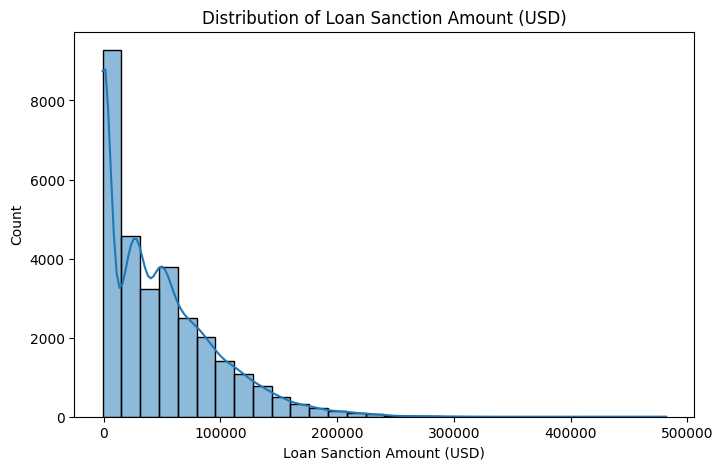

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(fs['Loan Sanction Amount (USD)'], kde=True, bins=30)
plt.title('Distribution of Loan Sanction Amount (USD)')
plt.show()


visualize feauture distribution

In [ ]:
plt.figure(figsize=(15,10))
for i, col in enumerate(fs.columns.drop('Loan Sanction Amount (USD)'), 1):
    plt.subplot(5, 5, i)  # adjust grid size depending on feature count
    sns.histplot(fs[col], kde=True)
    plt.title(col)
    plt.tight_layout()
plt.show()


correlation heatmap between feautures and target how a feauture is priorotized for the target

In [ ]:
plt.figure(figsize=(12,10))
corr = fs.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Scaled Features and Target')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 2: Separate features and target
# You must replace 'TargetColumnName' with your actual target column
X = fs.drop('Loan Sanction Amount (USD)', axis=1)  # Features
y = fs['Loan Sanction Amount (USD)']               # Target

# Step 3: Handle categorical features (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

# Step 4: Bin the target variable for Stratified K-Fold
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')

# Step 5: Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 6: Cross-validation
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []
adj_r2_scores = []

fold = 1
results = []

def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

saved = False

for train_idx, val_idx in skf.split(X, y_binned):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    if not saved:
        X_train = X_train_fold
        y_train = y_train_fold
        X_val = X_val_fold
        y_val = y_val_fold
        saved = True

    model = LinearRegression()
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)

    mae = mean_absolute_error(y_val_fold, y_pred)
    mse = mean_squared_error(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_fold, y_pred)
    adj_r2 = adjusted_r2(r2, X_val_fold.shape[0], X_val_fold.shape[1])

    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)

    results.append([f"Fold {fold}", mae, mse, rmse, r2, adj_r2])
    fold += 1

# Add average row
results.append([
    "Average",
    np.mean(mae_scores),
    np.mean(mse_scores),
    np.mean(rmse_scores),
    np.mean(r2_scores),
    np.mean(adj_r2_scores)
])

# Step 7: Display results
cv_results_df = pd.DataFrame(results, columns=["Fold", "MAE", "MSE", "RMSE", "R² Score", "Adjusted R² Score"])
print(cv_results_df)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



# -------------------- ACTUAL vs PREDICTED PLOT --------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=model.predict(X_val))
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.title("Actual vs Predicted Loan Amount (Validation Set)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')  # perfect prediction line
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------- RESIDUAL PLOT --------------------
residuals = y_val - model.predict(X_val)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=model.predict(X_val), y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Loan Amount")
plt.ylabel("Residuals")
plt.title("Residual Plot (Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Boxplots for numerical columns
numerical_cols = ['Income (USD)', 'Loan Amount Request (USD)', 'Age', 'Current Loan Expenses (USD)']

plt.figure(figsize=(14, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=fs[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()


In [ ]:
# Ensure LinearRegression was trained
model = LinearRegression()
model.fit(X_train, y_train)

# Bar plot of coefficients
coefficients = pd.Series(model.coef_, index=X_train.columns)

plt.figure(figsize=(10, 6))
coefficients.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Coefficients from Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.grid(True)
plt.tight_layout()
plt.show()
